# Importing Libraries

In [24]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


from imblearn.over_sampling import SMOTE
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns

# Loading and Preprocessing the Dataset

In [25]:
df = pd.read_csv('parkinsons_disease_data.csv')

df.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

categorical_cols = ['Gender', 'Ethnicity', 'EducationLevel']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

/Users/fabrizioferrara/Desktop/FDS Final Project/myenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/fabrizioferrara/Desktop/FDS Final Project/myenv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# Defining Support Functions for Training and Evaluation

In [26]:
def train_model(estimator, param_grid, model_name):
    grid_search = GridSearchCV(
        estimator=estimator, 
        param_grid=param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

def get_metrics(y_test, y_pred, y_prob, model_name):
    metrics = {
        "Model": model_name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1-Score": round(f1_score(y_test, y_pred), 3),
        "AUC": round(roc_auc_score(y_test, y_prob), 3)
    }
    return metrics

# Model Training and Optimization

In [27]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

best_rf_model = train_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")

param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

best_dt_model = train_model(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree")

param_grid_pruned_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30]
}

best_pruned_dt = train_model(DecisionTreeClassifier(random_state=42), param_grid_pruned_dt, "Decision Tree (Pruned)")


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Best parameters for Decision Tree (Pruned): {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 4, 'min_samples_split': 2}


# Feature Importance RF

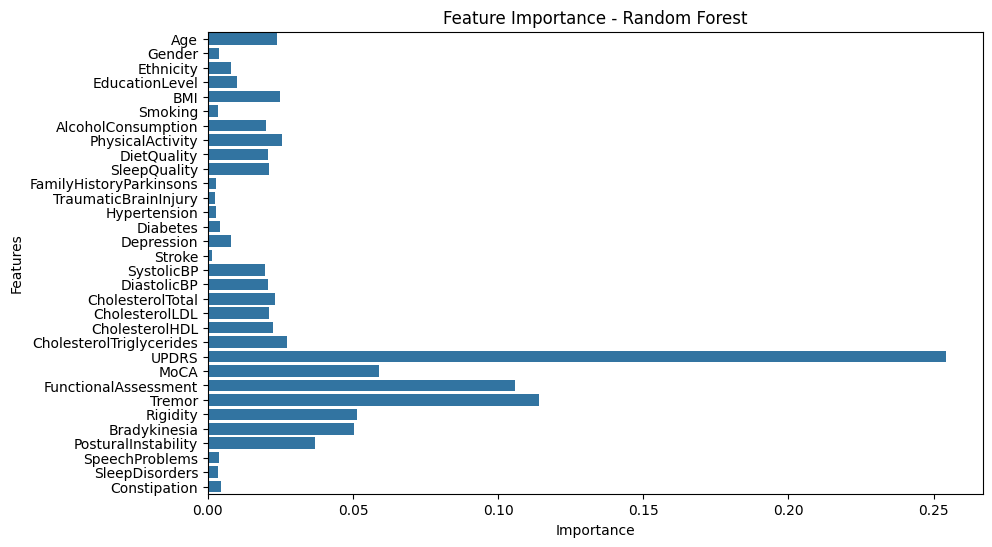

In [32]:
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Feature Importance DT-Pruned

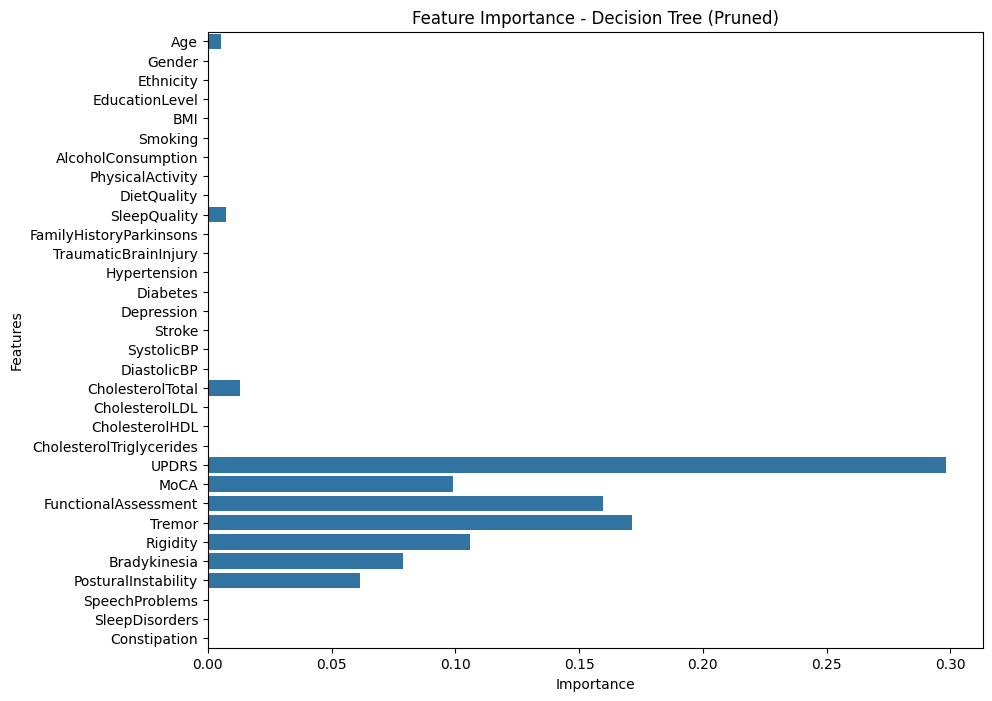

In [34]:
feature_importances_pruned = best_pruned_dt.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances_pruned, y=feature_names)
plt.title("Feature Importance - Decision Tree (Pruned)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Model Evaluation on the Test Set

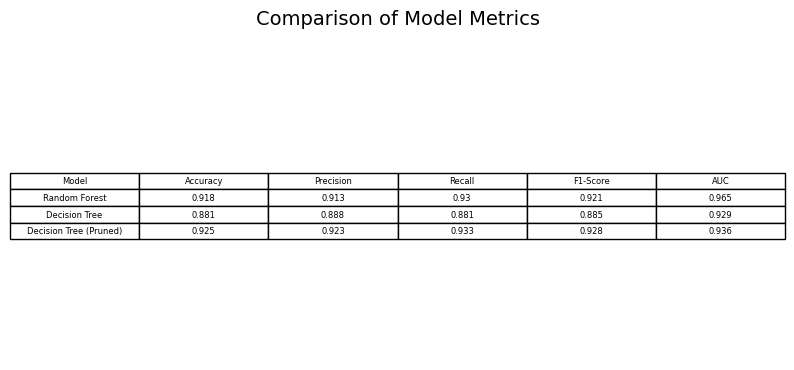

In [28]:
rf_metrics = get_metrics(y_test, best_rf_model.predict(X_test), best_rf_model.predict_proba(X_test)[:, 1], "Random Forest")
dt_metrics = get_metrics(y_test, best_dt_model.predict(X_test), best_dt_model.predict_proba(X_test)[:, 1], "Decision Tree")
pruned_dt_metrics = get_metrics(y_test, best_pruned_dt.predict(X_test), best_pruned_dt.predict_proba(X_test)[:, 1], "Decision Tree (Pruned)")

results_df = pd.DataFrame([rf_metrics, dt_metrics, pruned_dt_metrics])

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center', cellLoc='center')
plt.title("Comparison of Model Metrics", fontsize=14, pad=20)
plt.show()

# ROC Curve Visualization

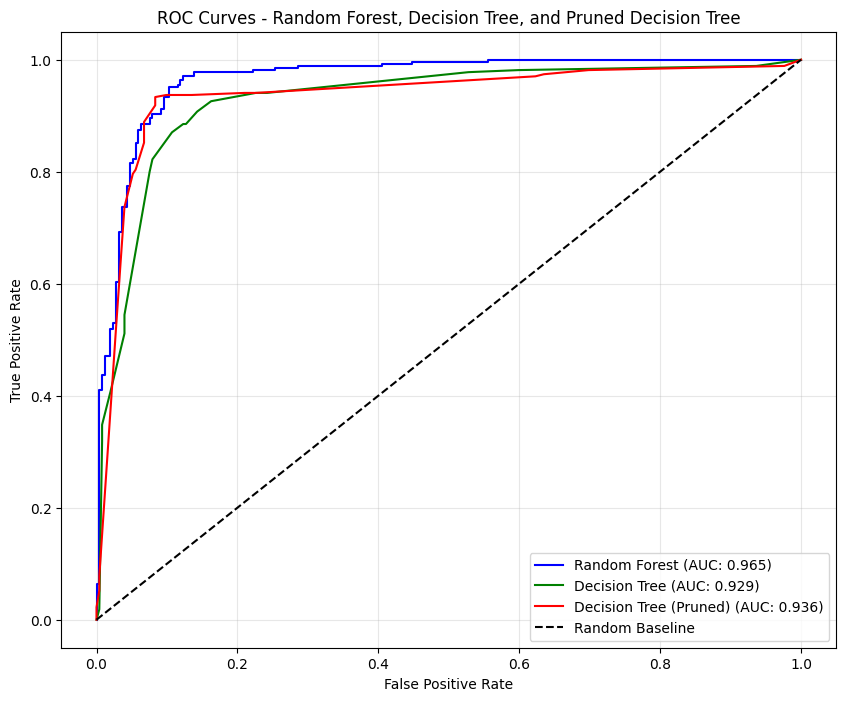

In [29]:
plt.figure(figsize=(10, 8))

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC: {rf_metrics['AUC']})", color='blue')

fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC: {dt_metrics['AUC']})", color='green')

fpr_pruned, tpr_pruned, _ = roc_curve(y_test, best_pruned_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_pruned, tpr_pruned, label=f"Decision Tree (Pruned) (AUC: {pruned_dt_metrics['AUC']})", color='red')

plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Random Forest, Decision Tree, and Pruned Decision Tree")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Learning Curve Visualization

In [30]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    best_rf_model, X_train, y_train, cv=5, scoring='accuracy'
)

train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(
    best_dt_model, X_train, y_train, cv=5, scoring='accuracy'
)

train_sizes_pruned, train_scores_pruned, test_scores_pruned = learning_curve(
    best_pruned_dt, X_train, y_train, cv=5, scoring='accuracy'
)

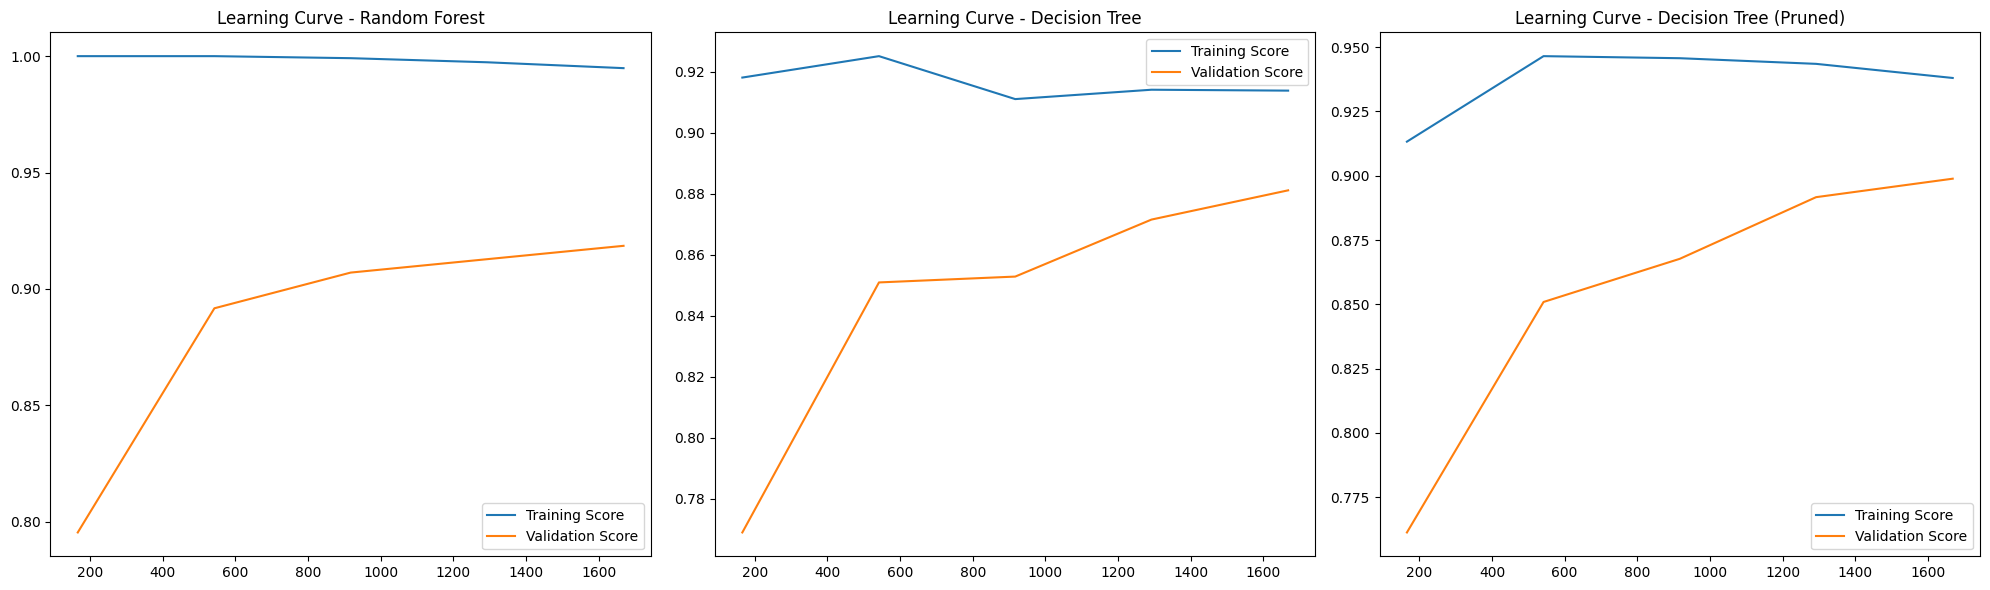

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(train_sizes_rf, train_scores_rf.mean(axis=1), label="Training Score")
axes[0].plot(train_sizes_rf, test_scores_rf.mean(axis=1), label="Validation Score")
axes[0].set_title("Learning Curve - Random Forest")
axes[0].legend()

axes[1].plot(train_sizes_dt, train_scores_dt.mean(axis=1), label="Training Score")
axes[1].plot(train_sizes_dt, test_scores_dt.mean(axis=1), label="Validation Score")
axes[1].set_title("Learning Curve - Decision Tree")
axes[1].legend()

axes[2].plot(train_sizes_pruned, train_scores_pruned.mean(axis=1), label="Training Score")
axes[2].plot(train_sizes_pruned, test_scores_pruned.mean(axis=1), label="Validation Score")
axes[2].set_title("Learning Curve - Decision Tree (Pruned)")
axes[2].legend()

plt.tight_layout()
plt.show()

# Classification Project for Parkinson’s Disease Diagnosis

The objective of this project was to diagnose Parkinson’s disease using machine learning models based on clinical and demographic data from 2,105 patients. The implemented models include Random Forest (RF), Decision Tree (DT), and an optimized version of the Decision Tree with Pre-Pruning. The main goal was to develop accurate, robust, and interpretable models by applying optimization and validation techniques.

Design Choices

The design choices were guided by specific considerations:
	•	Random Forest: Selected for its high performance, robustness, and ability to automatically handle irrelevant features.
	•	Decision Tree: Chosen for its high interpretability, crucial in a clinical context where understanding the decision-making process behind each prediction is essential.
	•	Pre-Pruning: Applied to the Decision Tree to simplify the tree structure without compromising accuracy.

Data Preprocessing

Data preprocessing was essential to ensure prediction quality. Irrelevant columns, “PatientID” and “DoctorInCharge”, were removed as they provided no useful information for diagnosis. Categorical variables such as Gender, Ethnicity, and EducationLevel were encoded using Label Encoding, while numerical features were normalized with StandardScaler.

To address the class imbalance in the dataset, SMOTE was applied, balancing the number of diagnosed and non-diagnosed patients and ensuring that the model was not biased toward the dominant class. Finally, the data was split into 80% for training and 20% for testing.

Random Forest

The Random Forest model was optimized using an exhaustive grid search (GridSearchCV) by tuning key parameters such as:
	•	n_estimators: Number of trees
	•	max_depth: Maximum depth of the trees
	•	min_samples_split: Minimum samples required to split a node
	•	min_samples_leaf: Minimum samples in leaf nodes

During validation with K-Fold Cross Validation, the model achieved an average accuracy of 92%. The learning curve showed a good balance between training and validation scores, indicating no overfitting. Feature importance analysis confirmed that UPDRS and MoCA were the most relevant features for predictions, consistent with clinical literature.

Test set results:
	•	Accuracy: 91.8%
	•	AUC: 0.965

The ROC Curve demonstrated the model’s excellent discriminative ability in distinguishing between positive and negative diagnoses.

Decision Tree

The Decision Tree model was optimized using GridSearchCV, tuning key parameters such as max_depth, min_samples_split, and min_samples_leaf.

Test set results:
	•	Accuracy: 88.1%
	•	AUC: 0.929

Despite its lower performance compared to Random Forest, the Decision Tree still demonstrated competitive results.

Decision Tree with Pre-Pruning

To improve the Decision Tree, Pre-Pruning was applied by limiting:
	•	max_depth: Maximum depth of the tree
	•	max_leaf_nodes: Maximum number of leaf nodes
	•	min_samples_split: Minimum samples required to split a node
	•	min_samples_leaf: Minimum samples required in leaf nodes

This technique significantly reduced the model’s complexity, improved generalization, and maintained high performance.

Test set results:
	•	Accuracy: 92.5%
	•	AUC: 0.936

The simplified model retained its high interpretability, making it ideal for clinical settings where transparency and clarity are crucial.

Comparative Analysis

The three models were compared using key metrics such as accuracy, precision, recall, F1-Score, and AUC. Below is the summary:
	•	Random Forest:
	•	Excellent overall performance with an AUC of 0.965.
	•	Robust and stable, though less interpretable.
	•	Decision Tree:
	•	Lower performance (AUC = 0.929).
	•	Highly interpretable due to its clear tree structure.
	•	Decision Tree with Pre-Pruning:
	•	Best balance between accuracy (92.5%) and interpretability.
	•	Reduced complexity and better control over overfitting.

Conclusions

The Random Forest proved to be the most performant model in terms of accuracy and discriminative ability, achieving an AUC of 0.965 with stable performance in both validation and test sets. However, the Decision Tree with Pre-Pruning offered a more interpretable solution while maintaining a competitive accuracy of 92.5% and strong generalization.

In clinical applications where interpretability is critical, the Decision Tree with Pre-Pruning emerges as the ideal model. At the same time, the Random Forest remains an excellent choice for highly reliable and robust predictions. Both models effectively identified UPDRS and MoCA as key features, confirming their importance in diagnosing Parkinson’s disease.